In [2]:
import pandas as pd
import nltk
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.callbacks import TensorBoard
import datetime

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [3]:
def calculate_metrics(df):
    """
    Calculates the average sentence length, average grammatical complexity, and average sentiment
    score for each row of text in the input DataFrame.
    
    Parameters:
        df (Pandas DataFrame): A DataFrame with a single column of text
    
    Returns:
        Pandas DataFrame: A new DataFrame with the columns 'average_sentence_length', 'average_grammatical_complexity',
        and 'average_sentiment'
    """
    # Define a function to calculate the POS tag count for a given sentence
    def pos_tag_count(sentence):
        pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        tag_count = len(pos_tags)
        return tag_count
    
    # Define a function to calculate the sentiment score for a given sentence
    def sentiment_score(sentence):
        blob = TextBlob(sentence)
        score = blob.sentiment.polarity
        return score
    
    # Tokenize the text into sentences
    sentences = df['prompt'].apply(nltk.sent_tokenize)
    
    # Calculate the average sentence length for each row
    df['average_sentence_length'] = sentences.apply(lambda x: sum(len(sentence.split()) for sentence in x)/len(x))
    
    # Calculate the average POS tag count for each row
    df['average_grammatical_complexity'] = sentences.apply(lambda x: sum(pos_tag_count(sentence) for sentence in x)/len(x))
    
    # Calculate the average sentiment score for each row
    df['average_sentiment'] = sentences.apply(lambda x: sum(sentiment_score(sentence) for sentence in x)/len(x))
    
    # Drop the 'sentences' column
    #df = df.drop('sentences', axis=1)
    
    return df[['average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']]


In [4]:
df2 = pd.read_excel("3class.xlsx")
df2

,prompt,completion
0,"\n\nIn the late 1800s, a woman by the name of ...",10thgrade
1,\n\nThe Hunt for Enemy Technology - Early Jets...,10thgrade
2,The Division of Labour\n\nThe division of labo...,6thgrade
3,\n\n“Yes the body:” A Quarantined Review of Sp...,10thgrade
4,"\n\nOnce upon a time, in a world far different...",6thgrade
...,...,...
295,\n\nThe History of Silicon Valley — A Brief Su...,6thgrade
296,\n\nYes the Body: A Quarantined Review of Spaw...,6thgrade
297,"\n\nAs I stand atop the Eildon Hills, overlook...",college
298,"\n\nAs human beings, we have always been fasci...",10thgrade


In [5]:
# Calculate the metrics
metrics_df2 = calculate_metrics(df2)
df2

print(list(df2.columns))

['prompt', 'completion', 'average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']


## all ai text model, 6th, 10th, college

In [6]:
# Load the data from the CSV file
# data = pd.read_csv("path/to/csv")
data = df2.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Encode the labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["completion"])
test_labels = label_encoder.transform(test_data["completion"])

# Convert the data to numpy arrays
train_prompt = np.array(train_data["prompt"])
train_numerical = np.array(train_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])
test_prompt = np.array(test_data["prompt"])
test_numerical = np.array(test_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])


In [7]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_prompt)
train_sequences = tokenizer.texts_to_sequences(train_prompt)
test_sequences = tokenizer.texts_to_sequences(test_prompt)

# Pad the sequences to be the same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")


In [8]:

# Define the inputs for the model
input_text = Input(shape=(max_length,))
input_numerical = Input(shape=(3,))

# Embed the text data
embedding = Embedding(input_dim=10000, output_dim=128)(input_text)
lstm1 = LSTM(32, kernel_regularizer=regularizers.l1(0.01))(embedding)
lstm2 = LSTM(16)(embedding)

# Combine the text
combined = Concatenate()([lstm1, input_numerical])

# Add some dropout for regularization
dropout = Dropout(0.2)(combined)

# Add a dense output layer
output = Dense(len(label_encoder.classes_), activation="softmax")(dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-21 14:13:06.136284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-21 14:13:06.136418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
learning_rate = 0.001
batch_size = 32

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit([train_padded, train_numerical], train_labels, validation_data=([test_padded, test_numerical], test_labels), epochs=500, batch_size=batch_size, callbacks=[tensorboard_callback])


2023-04-21 14:13:13.318448: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-21 14:13:13.318458: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-21 14:13:13.318533: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-21 14:13:13.391091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-21 14:13:13.391305: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500


2023-04-21 14:13:13.829319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-21 14:13:14.297118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-21 14:13:16.433790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/8 [==============>...............] - ETA: 0s - loss: 16.3183 - accuracy: 0.3672

2023-04-21 14:13:17.824726: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-21 14:13:17.824752: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-21 14:13:17.883715: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-21 14:13:17.884641: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-21 14:13:17.886044: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230421-141313/train/plugins/profile/2023_04_21_14_13_17
2023-04-21 14:13:17.886683: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20230421-141313/train/plugins/profile/2023_04_21_14_13_17/Aarons-MacBook-Pro.local.trace.json.gz
2023-04-21 14:13:17.888216: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230421-141313/train/plugins

8/8 [==============================] - ETA: 0s - loss: 16.3929 - accuracy: 0.3125

2023-04-21 14:13:19.142353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-21 14:13:19.197810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 6s 291ms/step - loss: 16.3929 - accuracy: 0.3125 - val_loss: 14.9225 - val_accuracy: 0.3000
Epoch 2/500
8/8 [==============================] - 0s 60ms/step - loss: 14.5346 - accuracy: 0.3542 - val_loss: 13.2205 - val_accuracy: 0.3000
Epoch 3/500
8/8 [==============================] - 0s 56ms/step - loss: 12.9481 - accuracy: 0.3083 - val_loss: 11.4268 - val_accuracy: 0.3000
Epoch 4/500
8/8 [==============================] - 0s 57ms/step - loss: 10.9862 - accuracy: 0.4042 - val_loss: 9.9347 - val_accuracy: 0.3167
Epoch 5/500
8/8 [==============================] - 0s 60ms/step - loss: 10.1097 - accuracy: 0.3333 - val_loss: 8.5700 - val_accuracy: 0.3333
Epoch 6/500
8/8 [==============================] - 0s 58ms/step - loss: 8.7110 - accuracy: 0.3750 - val_loss: 7.2234 - val_accuracy: 0.3333
Epoch 7/500
8/8 [==============================] - 0s 56ms/step - loss: 7.6468 - accuracy: 0.3458 - val_loss: 6.1051 - val_accuracy: 0.4667
Epoch 8/500
8/8 [======

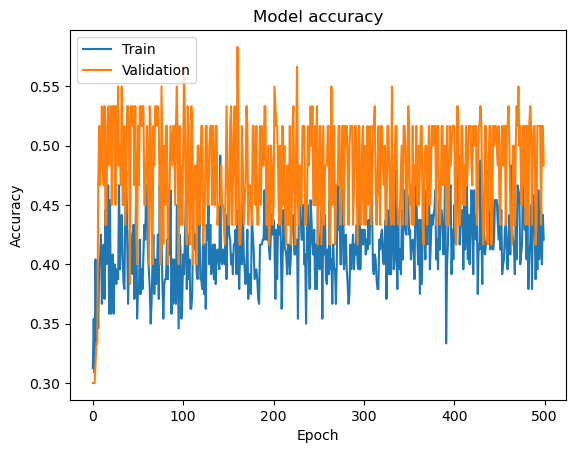

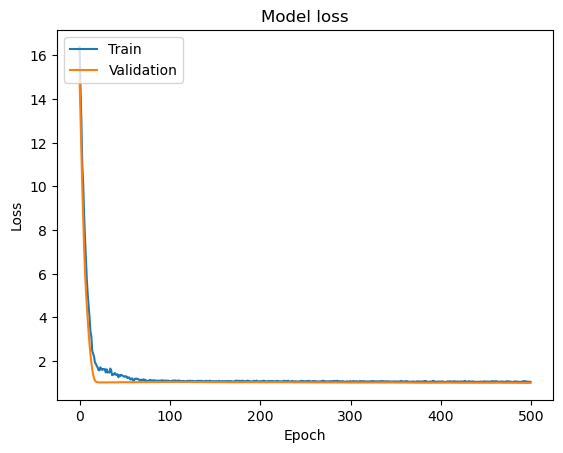

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [140]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)


2023-04-14 12:13:00.979915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 12:13:01.653323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training confusion matrix:
[[238   0]
 [  0 122]]
Test confusion matrix:
[[52 10]
 [ 1 27]]


In [23]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate([test_padded, test_numerical], test_labels)

# Print the testing accuracy
print("Test accuracy:", test_acc)


2/2 [==============================] - 0s 29ms/step - loss: 1.1928 - accuracy: 0.2500
Test accuracy: 0.25
